# Predicting Evergreeness of Content with Decision Trees and Random Forests

In [ ]:
## DATA DICTIONARY

In [9]:
import pandas as pd
import json
import math
data = pd.read_csv("../../assets/dataset/stumbleupon.tsv", sep='\t')
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))
data.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,title,body
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,24,0,5424,170,8,0.152941,0.079130,0,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,40,0,4973,187,9,0.181818,0.125448,1,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,55,0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight th...,Apples The most popular source of antioxidants...
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,24,0,2737,120,5,0.041667,0.100858,1,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot...
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,14,0,12032,162,10,0.098765,0.082569,0,The 50 Coolest Jerseys You Didn t Know Existed...,Jersey sales is a curious business Whether you...


In [15]:
data.alchemy_category.unique

<bound method Series.unique of 0                 business
1               recreation
2                   health
3                   health
4                   sports
5                        ?
6       arts_entertainment
7                        ?
8                        ?
9                        ?
10                business
11                  sports
12                  health
13                       ?
14              recreation
15              recreation
16              recreation
17      arts_entertainment
18              recreation
19                  health
20                  sports
21              recreation
22                  health
23                       ?
24                       ?
25                  sports
26                  sports
27                business
28                       ?
29                       ?
               ...        
7365                     ?
7366                     ?
7367                     ?
7368                     ?
7369                    

## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender. A description of the columns is below:

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
title|string|Title of the article
body|string|Body text of article
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonlinkratio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonlinkratio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonlinkratio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonlinkratio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?

> #### Evergreen sites are those that are always relevant.  As opposed to breaking news or current events, evergreen websites are relevant no matter the time or season. 

> #### A sample of URLs is below, where label = 1 are 'evergreen' websites

In [3]:
data[['url', 'label']].head()

,url,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,0
1,http://www.popsci.com/technology/article/2012-...,1
2,http://www.menshealth.com/health/flu-fighting-...,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,1
4,http://bleacherreport.com/articles/1205138-the...,0


### Exercises to Get Started

> ### Exercise: 1. In a group: Brainstorm 3 - 5 features you could develop that would be useful for predicting evergreen websites.
 ###  Exercise: 2. After looking at the dataset, can you model or quantify any of the characteristics you wanted?
- I.E. If you believe high-image content websites are likely to be evergreen, how can you build a feature that represents that?
- I.E. If you believe weather content is likely NOT to be evergreen, how might you build a feature that represents that?

### Split up and develop 1-3 of the those features independently.

> ### Exercise: 3. Does being a news site affect evergreeness? 
Compute or plot the percentage of news related evergreen sites.

In [39]:
# ... #
b = data[((data.label == 1) & (data.is_news == 1))].shape
print b

(0, 29)


In [37]:
data[['label','is_news']]

,label,is_news
0,0,1
1,1,1
2,1,1
3,1,1
4,0,1
5,0,?
6,1,1
7,0,?
8,1,1
9,1,?


In [42]:
news_ev = data.groupby(["label","is_news"]).apply(lambda group: len(group)).reset_index()

In [43]:
news_ev

,label,is_news,0
0,0,1,2199
1,0,?,1400
2,1,1,2353
3,1,?,1443


In [50]:
news_ev.columns = ['label','is_news','counts']

In [51]:
news_ev

,label,is_news,counts
0,0,1,2199
1,0,?,1400
2,1,1,2353
3,1,?,1443


In [53]:
total  = news_ev.counts.sum()

In [57]:
news_ev['percent_of_group'] = news_ev.counts.apply(lambda c: (float(c)/total)*100)

In [58]:
news_ev.head()

,label,is_news,counts,percent_of_group
0,0,1,2199,29.736308
1,0,?,1400,18.931711
2,1,1,2353,31.818796
3,1,?,1443,19.513185


In [60]:
data.groupby('label').size()

label
0    3599
1    3796
dtype: int64

> ### Exercise: 4. Does category in general affect evergreeness? 
Plot the rate of evergreen sites for all Alchemy categories.

In [65]:
# ... #

data.groupby('alchemy_category').size()

alchemy_category
?                     2342
arts_entertainment     941
business               880
computer_internet      296
culture_politics       343
gaming                  76
health                 506
law_crime               31
recreation            1229
religion                72
science_technology     289
sports                 380
unknown                  6
weather                  4
dtype: int64

In [68]:
newdf = data.dropna()

In [70]:
newdf.size

212483

/Users/leelewis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


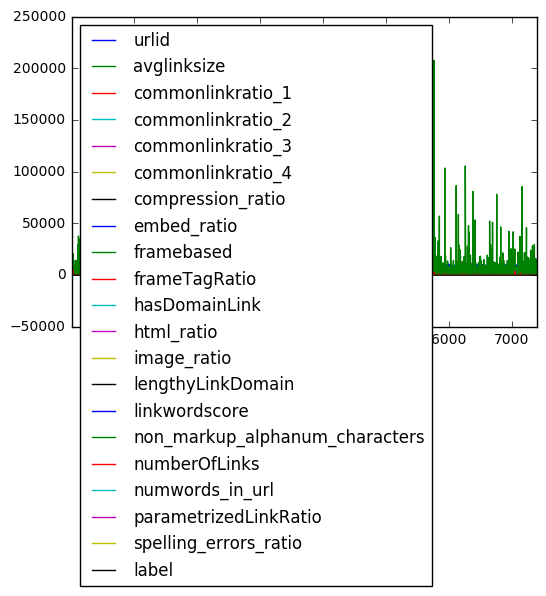

In [72]:
% matplotlib inline

newdf[data.label == 1].plot()

> ### Exercise: 5. How many articles are there per category?

In [ ]:
# ... #

> #### Let's try extracting some of the text content.
> ### Exercise: 6. Create a feature for the title containing 'recipe'. 
Is the % of evegreen websites higher or lower on pages that have recipe in the the title?

In [ ]:
# ... #

###  Let's Explore Some Decision Trees

 ### Demo: Build a decision tree model to predict the "evergreeness" of a given website. 

Index([u'url', u'urlid', u'boilerplate', u'alchemy_category',
       u'alchemy_category_score', u'avglinksize', u'commonlinkratio_1',
       u'commonlinkratio_2', u'commonlinkratio_3', u'commonlinkratio_4',
       u'compression_ratio', u'embed_ratio', u'framebased', u'frameTagRatio',
       u'hasDomainLink', u'html_ratio', u'image_ratio', u'is_news',
       u'lengthyLinkDomain', u'linkwordscore', u'news_front_page',
       u'non_markup_alphanum_characters', u'numberOfLinks', u'numwords_in_url',
       u'parametrizedLinkRatio', u'spelling_errors_ratio', u'label', u'title',
       u'body'],
      dtype='object')

In [66]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

X = data[['image_ratio', 'html_ratio', 'recipe', 'label']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)
    
    
# Fits the model
model.fit(X, y)

# Helper function to visualize Decision Trees (creates a file tree.png)

from sklearn.tree import export_graphviz
from os import system 
def build_tree_image(model):
    dotfile = open("tree.dot", 'w')
    export_graphviz(model,
                              out_file = dotfile,
                              feature_names = X.columns)
    dotfile.close()
    system("dot -Tpng tree.dot -o tree.png")
    
build_tree_image(model)

KeyError: "['recipe'] not in index"

## Decision Trees in scikit-learn

 ### Exercise: Evaluate the decision tree using cross-validation; use AUC as the evaluation metric.

In [ ]:
from sklearn.cross_validation import cross_val_score

# ... #

###  Adjusting Decision Trees to Avoid Overfitting

 ### Demo: Control for overfitting in the decision model by adjusting the maximum number of questions (max_depth) or the minimum number of records in each final node (min_samples_leaf)

In [ ]:
model = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5)

model.fit(X, y)
build_tree_image(model)

 ### Demo: Build a random forest model to predict the evergreeness of a website. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20)
    
model.fit(X, y)

### Demo: Extracting importance of features

In [ ]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort('Importance Score', inplace=True, ascending=False)

features_df.head()

 ### Exercise: Evaluate the Random Forest model using cross-validation; increase the number of estimators and view how that improves predictive performance.

In [ ]:
# ... #

##  Independent Practice: Evaluate Random Forest Using Cross-Validation

1. Continue adding input variables to the model that you think may be relevant
2. For each feature:
  - Evaluate the model for improved predictive performance using cross-validation
  - Evaluate the _importance_ of the feature
  - 
3. **Bonus**: Just like the 'recipe' feature, add in similar text features and evaluate their performance.


In [ ]:
# ... #